# reCoach

In [1]:
# Choose player name
#player_name = "Beginner"
player_name = "Intermediate"

In [2]:
import scripts

In [212]:
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

In [4]:
def transform_state(stateflags):
    '''
    Transforms state from sum-on-powers-of-2 integer to one-hot encoding array;
    Returns array:
    0) PlayerStateNone
    1) PlayerStateAlive
    2) PlayerStateShooting
    3) PlayerStateTakingDamage
    4) PlayerStateSpawned
    5) PlayerStateDespawned
    6) PlayerStateKilled
    '''
    # Copy argument
    sf = stateflags
    i = 1
    # Explicit flags
    flags = np.zeros(7)
    flags[0] = 1
    
    while sf > 0:
        if sf % 2 != 0:
            flags[i] = 1
            flags[0] = 0
        sf = sf // 2
        i += 1
    
    return flags

In [5]:
def get_killer_entry(player_name, session_id):
    '''
    Returns entry "killer" who killed player defined by player_name in session defined by session_id
    '''
    
    # Get frame_number from one_player_state that corresponds to one player death in one session
    row = np.nonzero((one_player_state["stateflags"] // 32 == 1) & (one_player_state["sessionid"] == session_id))[0][0]
    #row = np.nonzero((transform_state(stateflags)[6] == 1) & (one_player_state["sessionid"] == session_id))[0][0]
    entry = one_player_state.iloc[row]
    frame_number = entry["framenumber"]
    
    # Get row from game_frame that corresponds to the frame
    row = np.nonzero((game_frame["sessionid"] == session_id) & (game_frame["framenumber"] == frame_number))[0][0]
    json_entry_players = json.loads(game_frame.iloc[row]["players"])
    
    # Define the killer
    entry_killer = None
    # For every player in JSON entry for game frame
    for player_info in json_entry_players:
        # If flag "attacking/shooting" is 1, consider player as a killer
        if (int(transform_state(player_info["state"]["state"]["stateflags"])[2]) == 1):
            entry_killer = player_info
    if entry_killer == None:
        return -1
    
    # Return JSON entry with a killer
    return entry_killer

In [6]:
def get_basic_stats(player_name):
    '''
    Get some basic statistics
    '''
        
    # Session duration, accuracy, kill distance
    print("--- Player's name:", player_name, "---")
    print("Average session duration:\t", np.average(one_player_session["session_duration_seconds"]))
    print("Average accuracy:\t\t",
          np.average(one_player_session.iloc[np.nonzero(one_player_session["accuracy"])]["accuracy"]))
    print("Average kill distance:\t\t",
          np.average(one_player_session.iloc[np.nonzero(one_player_session["average_kill_distance"])]["average_kill_distance"]))

    # Get sessions where player died
    session_ids_player_died = np.asarray(one_player_state[one_player_state["stateflags"] // 32 == 1]["sessionid"])
    #session_ids_player_died = np.asarray(one_player_state[transform_state(stateflags)[6] == 1]["sessionid"])
    # Get weapons by which player was killed
    weapons = []
    for session_id in session_ids_player_died:
        killer_entry = get_killer_entry(player_name, session_id)
        if killer_entry == -1:
            weapons.append(-1)
        else:
            weapon_id = killer_entry["state"]["state"]["weapon_id"]
            weapon_name = weapon_desc[weapon_desc["id"] == weapon_id]["name"].iloc[0]
            weapons.append(weapon_name)

    print("In last sessions you was killed by following weapons:", weapons)

In [4]:
def get_graphs(player_name, step):
    '''
    Build graphs representing dynamics of player progress
    '''
    
    # Dynamics
    rows = one_player_session.shape[0]
    print("Total sessions:", rows)
    point_avg_rows = rows // step

    # Average session duration averaged over 'step' sessions
    average_session_duration = np.zeros(point_avg_rows)

    for i in range(point_avg_rows):
        average_session_duration[i] = (np.average(one_player_session["session_duration_seconds"].iloc[:(i+1)*step]))

    plt.plot(average_session_duration, marker='.')
    return average_session_duration

In [5]:
def get_frames_player_session(player_name, session_ind):
    
    # Get all states among all sessions for one player
    one_player_state = player_state[player_state["playerguid"] == player_name]
    # Get all sessions player played
    sessions_player = np.unique(one_player_state["sessionid"])
    # Get session_id of the last session
    session_id = sessions_player[-session_ind]
    # State of one player for one session
    one_player_state_session = player_state[(player_state["playerguid"] == player_name) & (player_state["sessionid"] == session_id)]
    # Sort rows by time
    one_player_state_session = one_player_state_session.sort_values(["framenumber"])
    return one_player_state_session

In [ ]:
def get_tracks_positions_player_killer(one_player_state_session):
    
    

In [6]:
filenames = [
    "../game_frame.csv",
    "../game_session.csv",
    "../player_session.csv",
    "../player_state.csv",
    "../weapon_desc.csv"
]
game_frame = pd.read_csv(filenames[0])
game_session = pd.read_csv(filenames[1])
player_session = pd.read_csv(filenames[2])
player_state = pd.read_csv(filenames[3])
weapon_desc = pd.read_csv(filenames[4])

# Recent sessions

**Take some info for specific player from recent sessions**

In [7]:
#sessions_nr = 10
# Take rows from tables which are specific to this player
one_player_session = player_session[player_session["playerguid"] == player_name]
one_player_state = player_state[player_state["playerguid"] == player_name]
# Sort by session order
one_player_session = one_player_session.sort_values("sessionid")
one_player_state = one_player_state.sort_values(["sessionid", "framenumber"])

one_player_session.head(5)

,gameid,playerguid,sessionid,playername,session_duration_seconds,kills,deaths,longest_kill_streak,average_kill_distance,shortest_kill_distance,longest_kill_distance,accuracy
168,185,Intermediate,2687592411388294992,NaN,611,2,0,2,1069.628052,294.336884,1844.919312,60.000004
224,185,Intermediate,2687592411391066647,NaN,758,2,1,2,818.735291,221.091965,1416.378662,33.333336
17,185,Intermediate,4959622521747852516,NaN,698,0,1,0,0.000000,0.000000,0.000000,0.000000
23,185,Intermediate,4959622521747980894,NaN,492,0,1,0,0.000000,0.000000,0.000000,0.000000
37,185,Intermediate,4959622521748053636,NaN,910,2,0,2,893.041382,299.740051,1486.342651,66.666672


Get basic stats

In [8]:
basic_stats = scripts.get_basic_stats(player_name, one_player_session, one_player_state, game_frame, weapon_desc)
avg_session_duration = basic_stats[0]
avg_accuracy = basic_stats[1]
avg_kill_distance = basic_stats[2]
killed_by = basic_stats[3]
print("--- Player's name:", player_name, "---")
print("Average session duration:\t", avg_session_duration)
print("Average accuracy:\t", avg_accuracy)
print("Average kill distance:\t", avg_kill_distance)
print("Killed by:\t", killed_by)

--- Player's name: Intermediate ---
Average session duration:	 620.3333333333334
Average accuracy:	 72.00000228881837
Average kill distance:	 975.504562377928
Killed by:	 [-1, 'WarriorArrow', -1, -1, -1, -1, 'WarriorArrow']


Get graphs

Total sessions: 9


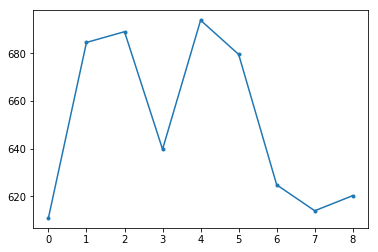

In [225]:
session_duration = get_graphs(player_name, step=1)

In [10]:
session_duration

array([611.        , 684.5       , 689.        , 639.75      ,
       693.8       , 679.5       , 624.85714286, 614.        ,
       620.33333333])

# Player death

**Last frames before death; one player, one session**

In [14]:
# Get all sessions player played
sessions_player = np.unique(one_player_state["sessionid"])
# Get session_id of the last session
session_id = sessions_player[-1]
# State of one player for one session
#one_player_state_session = player_state[(player_state["playerguid"] == player_name) & (player_state["sessionid"] == session_id)]
# Sort rows by time
#one_player_state_session = one_player_state_session.sort_values(["framenumber"])
#one_player_state_session

In [15]:
one_player_state_session = get_frames_player_session(player_name, 1)
one_player_state_session

,gameid,sessionid,playerguid,framenumber,frametime_ms,posX,posY,posZ,viewW,viewX,viewY,viewZ,tickflags,stateflags,fov,health,weapon_id
933094,185,8330405089890209083,Intermediate,6905,61,-121724.656250,-2326.504150,2253.629150,-0.995772,0.002836,0.032949,0.085703,0,4,0,0,0
933228,185,8330405089890209083,Intermediate,6983,1064,-122631.539062,-2821.842529,2340.859619,-0.149404,0.127642,-0.019453,-0.980310,0,2,90,0,11
933310,185,8330405089890209083,Intermediate,7039,252,-124024.234375,-1847.363281,2253.628174,0.121730,0.015273,0.001873,-0.992444,0,2,90,0,11
933346,185,8330405089890209083,Intermediate,7052,404,-124266.429688,-2001.375610,2253.628174,0.129667,0.017348,0.002269,-0.991403,0,0,90,0,11
933348,185,8330405089890209083,Intermediate,7053,34,-124291.039062,-2019.240845,2253.628174,0.129571,0.017539,0.002292,-0.991412,0,0,90,0,11
933409,185,8330405089890209083,Intermediate,7111,406,-124218.281250,-2254.958252,2253.628174,-0.147484,0.008107,-0.001209,-0.989030,0,2,90,0,14
933411,185,8330405089890209083,Intermediate,7113,61,-124222.968750,-2253.824219,2253.628174,-0.147532,0.008155,-0.001216,-0.989023,0,0,90,0,14
933551,185,8330405089890209083,Intermediate,7167,1127,-125381.453125,-2162.895996,2253.628174,0.246698,0.001301,-0.000331,0.969091,0,2,90,0,11
933553,185,8330405089890209083,Intermediate,7180,406,-125543.640625,-1982.045532,2253.628174,-0.245629,0.001905,-0.000483,-0.969362,0,0,90,0,11
933555,185,8330405089890209083,Intermediate,7182,62,-125548.921875,-1965.217651,2253.628174,-0.245350,0.001905,-0.000482,-0.969432,0,0,90,0,11


In [16]:
# Get frame number when player died
frame_number_death = one_player_state_session.iloc[-1]["framenumber"]

In [19]:
# Get game_frame row based on session and frame
row = np.nonzero((game_frame["sessionid"] == session_id) & (game_frame["framenumber"] == frame_number_death))[0][0]
json_entry_players = json.loads(game_frame.iloc[row]["players"])
# Get killer
killer = scripts.get_killer_entry(player_name, session_id, one_player_state, game_frame)
# Get killer name
killer_name = None
try:
    killer_name = killer["guid"]
except:
    pass
print(killer_name)

Rhonda_Chung


In [20]:
# Take frames up until the death in last session (choose step)
step = 100
last_positions_player = one_player_state_session.iloc[:-1: step][["posX", "posY"]]
last_positions_player

,posX,posY
933094,-121724.656250,-2326.504150
948206,16862.761719,-10929.232422
951762,15952.082031,-7780.691406
954135,13025.660156,-8440.843750
956332,13022.898438,-8522.100586
959355,9012.427734,-10035.959961
962993,6512.412109,-7314.985840
964731,5976.621582,-3677.649658
967853,4953.896484,-779.899414
969566,4865.256348,3807.877930


In [21]:
# Get last frames for the killer, up until death of the player
killer_state_session = player_state[(player_state["playerguid"] == killer_name) & (player_state["sessionid"] == session_id)]
killer_state_session = killer_state_session.sort_values("framenumber")
killer_state_session_until_death = killer_state_session[killer_state_session["framenumber"] < frame_number_death]
last_positions_killer = killer_state_session_until_death.iloc[:-1: step][["posX", "posY"]]
last_positions_killer

,posX,posY
920270,-121050.898438,-1343.484375
936279,-121278.031250,-2161.421631
945527,-124636.796875,-3130.326660
951155,-22158.523438,-31707.091797
953582,-25259.539062,-34628.636719
955867,-27378.181641,-37222.375000
958107,-28260.162109,-38218.664062
960005,-25193.720703,-38253.960938
962209,-24482.978516,-38508.230469
963984,-27576.042969,-42131.042969


**Positions and movement of players**

Killing distance: 669650.7876319885


Text(0, 0.5, 'Y')

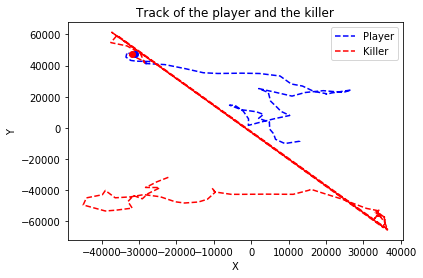

In [27]:
# Coordinates of player and killer at the moment of kill
coord_player = np.asarray(one_player_state_session[one_player_state_session["framenumber"] == frame_number_death][["posX", "posY"]].iloc[0])
coord_killer = np.asarray(killer_state_session[killer_state_session["framenumber"] == frame_number_death][["posX", "posY"]].iloc[0])

# Killing distance
killing_dist = np.sum((coord_player - coord_killer) ** 2)
print("Killing distance:", killing_dist)

# Tracks of a player and a killer since start until killing
plt.plot(np.asarray(last_positions_player)[3:,0], np.asarray(last_positions_player)[3:,1], '--', color='blue')
plt.plot(np.asarray(last_positions_killer)[3:,0], np.asarray(last_positions_killer)[3:,1], '--', color='red')
plt.plot(coord_player[0], coord_player[1], 'o', color='blue')
plt.plot(coord_killer[0], coord_killer[1], 'o', color='red')
plt.title("Track of the player and the killer")
plt.legend(["Player", "Killer"])
plt.xlabel("X")
plt.ylabel("Y")

In [23]:
# Export data into JSON
with open('data/data.json', 'w') as outfile:
    json.dump({"sessionDurationData": session_duration.tolist(),
              "movementData": np.array(last_positions_player).tolist()},
              outfile)

In [24]:
player_state[player_state["playerguid"] == "Michael_Bowman"].describe()

,gameid,sessionid,framenumber,frametime_ms,posX,posY,posZ,viewW,viewX,viewY,viewZ,tickflags,stateflags,fov,health,weapon_id
count,13208.0,1.320800e+04,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.000000,13208.0,13208.000000,13208.000000
mean,185.0,6.300480e+18,22761.564809,32.158465,32943.409843,-5896.536210,1385.969980,0.015321,0.057489,0.000185,-0.474202,3.655966,1.019836,90.0,542.169367,18.530209
std,0.0,0.000000e+00,6658.749055,41.885550,26593.133756,9985.873605,758.943378,0.656659,0.053129,0.074472,0.576265,10.180013,0.486573,0.0,135.157076,9.636169
min,185.0,6.300480e+18,6198.000000,23.000000,-125068.453125,-23735.675781,224.404724,-0.999754,0.000000,-0.449811,-0.999975,0.000000,0.000000,90.0,0.000000,11.000000
25%,185.0,6.300480e+18,17519.500000,30.000000,3040.343201,-11530.344238,909.264191,-0.634890,0.019064,-0.038867,-0.905680,0.000000,1.000000,90.0,600.000000,18.000000
50%,185.0,6.300480e+18,23870.000000,31.000000,39541.203125,-5064.280273,1190.993958,0.057678,0.044972,-0.004376,-0.682765,0.000000,1.000000,90.0,600.000000,18.000000
75%,185.0,6.300480e+18,28555.000000,31.000000,55491.761719,-2122.065186,1773.123932,0.634718,0.078187,0.032371,-0.304610,0.000000,1.000000,90.0,600.000000,18.000000
max,185.0,6.300480e+18,32650.000000,2790.000000,75303.812500,19358.673828,4963.423340,0.999960,0.385966,0.490187,0.999950,32.000000,52.000000,90.0,600.000000,106.000000


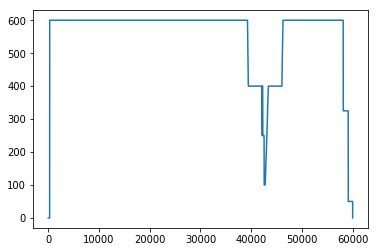

In [306]:
plt.plot(player_state[player_state["playerguid"] == "Michael_Bowman"]["health"])

In [307]:
player_state[player_state["playerguid"] == "Michael_Bowman"]["health"].shape

(13208,)

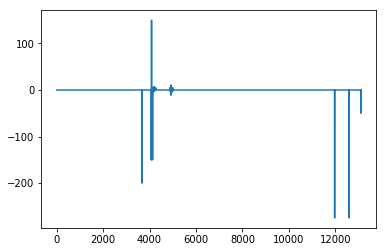

In [308]:
plt.plot(np.diff(player_state[player_state["playerguid"] == "Michael_Bowman"]["health"][100:]))

# Suggestions

In [219]:
# player_state, we need all sessions
# Get sessions where player died
session_ids_player_died = np.asarray(one_player_state[one_player_state["stateflags"] // 32 == 1]["sessionid"])

# Take one session (e.g. last one)
session_id = session_ids_player_died[-1]

# Take rows where player was receiving damage
rows_hit = one_player_state_session[one_player_state_session["stateflags"] // 4 == 1]
# Take rows where player wasn't receiving damage
rows_ok = one_player_state_session[one_player_state_session["stateflags"] // 4 == 0]

In [220]:
X_good = np.asarray(rows_ok[["posX", "posY", "posZ", "viewW", "viewX", "viewY", "viewZ", "fov", "weapon_id"]])
y_good = np.zeros(X_good.shape[0])
X_bad = np.asarray(rows_hit[["posX", "posY", "posZ", "viewW", "viewX", "viewY", "viewZ", "fov", "weapon_id"]])
y_bad = np.ones(X_bad.shape[0])
X = np.concatenate((X_good, X_bad))
y = np.concatenate((y_good, y_bad))

In [221]:
logreg = LogisticRegression()
logreg.fit(X, y)

/home/corvus/programs/anaconda3/envs/py36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [216]:
rows_ok

,gameid,sessionid,playerguid,framenumber,frametime_ms,posX,posY,posZ,viewW,viewX,viewY,viewZ,tickflags,stateflags,fov,health,weapon_id
913418,185,4959622521767604976,Intermediate,15280,32,-4679.841797,39964.210938,280.393585,0.505780,0.091574,0.054103,-0.856081,0,1,90,600,11
913425,185,4959622521767604976,Intermediate,15282,30,-4666.377441,39918.222656,270.645264,0.506315,0.092153,0.054528,-0.855675,0,1,90,600,11
913432,185,4959622521767604976,Intermediate,15284,32,-4653.119629,39872.742188,261.653656,0.506688,0.092701,0.054912,-0.855370,0,1,90,600,11
913439,185,4959622521767604976,Intermediate,15286,29,-4645.113770,39802.480469,249.765701,0.506917,0.093584,0.055478,-0.855102,0,1,90,600,11
913446,185,4959622521767604976,Intermediate,15290,29,-4677.400391,39693.390625,241.412964,0.505594,0.093833,0.055432,-0.855860,0,1,90,600,11
913453,185,4959622521767604976,Intermediate,15292,30,-4696.794922,39650.109375,239.960892,0.505143,0.093863,0.055382,-0.856127,0,1,90,600,11
913460,185,4959622521767604976,Intermediate,15294,32,-4727.525879,39588.964844,238.355560,0.504546,0.093615,0.055145,-0.856521,0,1,90,600,11
913467,185,4959622521767604976,Intermediate,15296,32,-4750.062012,39546.281250,237.709747,0.504052,0.091724,0.053942,-0.857093,0,1,90,600,11
913474,185,4959622521767604976,Intermediate,15298,30,-4771.076172,39507.300781,237.126740,0.503757,0.090555,0.053203,-0.857437,0,1,90,600,11
913481,185,4959622521767604976,Intermediate,15300,31,-4811.166016,39434.015625,236.610062,0.503563,0.089052,0.052279,-0.857765,0,1,90,600,11


Check model on another session

In [209]:
# Another session
session_id = session_ids_player_died[-3]
# 
another_player_state_session = player_state[(player_state["sessionid"] == session_id) & (player_state["playerguid"] == player_name)]
# Take rows where player was receiving damage
rows_hit = another_player_state_session[another_player_state_session["stateflags"] // 4 == 1]
# Take rows where player wasn't receiving damage
rows_ok = another_player_state_session[another_player_state_session["stateflags"] // 4 == 0]

X_good = np.asarray(rows_ok[["posX", "posY", "posZ", "viewW", "viewX", "viewY", "viewZ", "fov", "weapon_id"]])
y_good = np.zeros(X_good.shape[0])
X_bad = np.asarray(rows_hit[["posX", "posY", "posZ", "viewW", "viewX", "viewY", "viewZ", "fov", "weapon_id"]])
y_bad = np.ones(X_bad.shape[0])
X = np.concatenate((X_good, X_bad))
y = np.concatenate((y_good, y_bad))

In [210]:
logreg.score(X, y)

0.9959390862944163

In [222]:
X_new = SelectKBest(f_classif, k=3).fit_transform(X, y)
X_new.shape

(5530, 3)

In [223]:
X_new

array([[-1.22631539e+05, -2.82184253e+03,  9.00000000e+01],
       [-1.24024234e+05, -1.84736328e+03,  9.00000000e+01],
       [-1.24266430e+05, -2.00137561e+03,  9.00000000e+01],
       ...,
       [-2.83846445e+04,  4.17090273e+04,  9.00000000e+01],
       [-3.32660703e+04,  4.78868164e+04,  9.00000000e+01],
       [-3.14430801e+04,  4.68522148e+04,  9.00000000e+01]])

From the first view, it seems that most important features to predict how good player's gameplay is, are XY position.